# Librerias

In [1]:
import datatree
import xradar as xd
import xarray as xr
import cmweather
import numpy as np
import hvplot.xarray
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from xarray.core.datatree import DataTree

### Dask cluster (Computo paralelo y distribuido)

In [25]:
cluster = LocalCluster()  
client = Client(cluster)

/data/keeling/a/alfonso8/miniconda3/envs/raw2zarr/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43159 instead
  warnings.warn(


In [26]:
client

<Client: 'tcp://127.0.0.1:37054' processes=4 threads=12, memory=48.00 GiB>

### Lectura datos

In [4]:
path = "/data/scratch/a/alfonso8/Guaviare.zarr"

In [5]:
dtree = xr.backends.api.open_datatree(
    path, 
    engine='zarr', 
    chunks={}
)

In [27]:
dtree

<xarray.DataTree>
Group: /
│   Dimensions:              ()
│   Data variables:
│       altitude             float64 8B ...
│       instrument_type      <U5 20B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       platform_type        <U5 20B ...
│       time_coverage_end    <U20 80B ...
│       time_coverage_start  <U20 80B ...
│       volume_number        int64 8B ...
│   Attributes:
│       Conventions:      None
│       comment:          im/exported using xradar
│       history:          None
│       institution:      None
│       instrument_name:  None
│       references:       None
│       source:           None
│       title:            None
│       version:          None
├── Group: /radar_parameters
│       Dimensions:    ()
│       Coordinates:
│           altitude   float64 8B ...
│           latitude   float64 8B ...
│           longitude  float64 8B ...
│       Data variables:
│           *empty*
├── Group: /sweep_0
│       Dimensions:            (vcp_time: 2894, azimuth: 720, range: 994)
│       Coordinates:
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 3kB 0.25 0.75 1.25 ... 359.2 359.8
│           crs_wkt            int64 8B ...
│           elevation          (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│         * vcp_time           (vcp_time) datetime64[ns] 23kB 2022-06-01T00:00:11.780...
│           x                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
│           y                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
│           z                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
│       Data variables: (12/17)
│           DBTH               (vcp_time, azimuth, range) float32 8GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DBZH               (vcp_time, azimuth, range) float32 8GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_DBTE8           (vcp_time, azimuth, range) float32 8GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_DBZE8           (vcp_time, azimuth, range) float32 8GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_HCLASS          (vcp_time, azimuth, range) int16 4GB dask.array<chunksize=(1, 360, 497), meta=np.ndarray>
│           KDP                (vcp_time, azimuth, range) float32 8GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           ...                 ...
│           ZDR                (vcp_time, azimuth, range) float32 8GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           follow_mode        (vcp_time) <U7 81kB dask.array<chunksize=(1,), meta=np.ndarray>
│           prt_mode           (vcp_time) <U7 81kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_fixed_angle  (vcp_time) float64 23kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_mode         (vcp_time) <U20 232kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_number       (vcp_time) int64 23kB dask.array<chunksize=(1,), meta=np.ndarray>
├── Group: /sweep_1
│       Dimensions:            (vcp_time: 2883, azimuth: 360, range: 747)
│       Coordinates:
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           crs_wkt            int64 8B ...
│           elevation          (azimuth) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float3

In [28]:
dtree['sweep_0'].ds.vcp_time.min().values, dtree['sweep_0'].ds.vcp_time.max().values

(numpy.datetime64('2022-06-01T00:00:11.780999936'),
 numpy.datetime64('2022-06-12T20:45:20.756999936'))

In [29]:
print(f'size: {dtree.nbytes / (1024 ** 3)} GB')

size: 360.6229046359658 GB


### Quasy-Vertical profile [(Ryzhkov et al., 2016)](https://journals.ametsoc.org/view/journals/atot/33/3/jtech-d-15-0020_1.xml)
<div>
<img src="pictures/full-jtech-d-15-0020_1-f2.jpg" width="300"/>
<img src="pictures/full-jtech-d-15-0020_1-f4.jpg" width="350"/>

</div>

In [30]:
dtree['sweep_9'].ds.sweep_fixed_angle.values[0]

15.0

Accedemos y convertimos la reflectividad a unidades lineales del `sweep_9` (15° elevacion) 

In [32]:
qvp = 10 ** (dtree['sweep_9'].ds.DBZH / 10)

Tomamos la media a lo largo de la dimension `azimuth`

In [33]:
qvp = qvp.mean('azimuth')

Volvemos a convertir a dBZ

In [34]:
qvp = 10 * np.log10(qvp)

Asignamos nuevas cordenadas de acuerdo al ángulo selecionado

In [35]:
qvp = qvp.assign_coords(range=(qvp.range.values * 
                                 np.sin(dtree['sweep_9'].to_dataset().sweep_fixed_angle.values.mean() *  
                                        np.pi / 180. ) ))

Generamos nuestra gráfica de QVP para el evento selecionado

CPU times: user 2.08 s, sys: 192 ms, total: 2.28 s
Wall time: 2.31 s


Text(0, 0.5, 'Heigth')

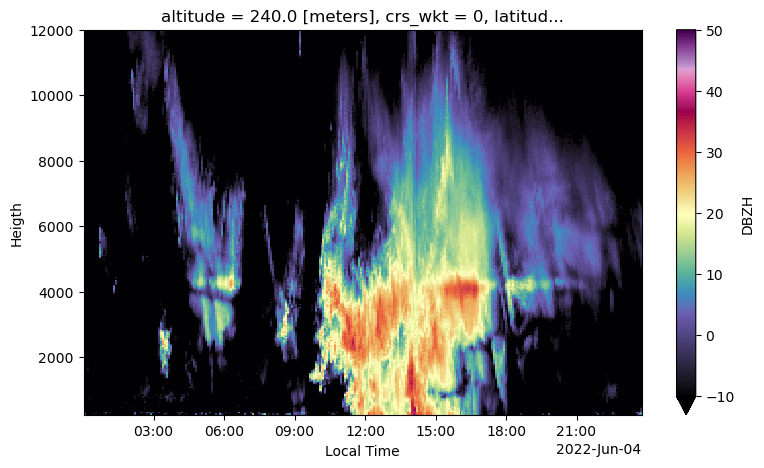

In [38]:
%%time
fig, ax = plt.subplots(figsize=(9, 5))
qvp.sel(range=slice(0, 12000), 
         vcp_time='2022-06-04').plot(
    x='vcp_time', 
    y='range', 
    cmap='ChaseSpectral', 
    vmin=-10, 
    vmax=50, 
    ax=ax
)
ax.set_xlabel("Local Time")
ax.set_ylabel("Heigth")

## Estimación cuantitiva de la precipitación 

Podemos tambien estimar cuantivivamente la precipitación usando la relación de [Marshall and Gunn](https://www.sciencedirect.com/science/article/pii/S0065268708603106?via%3Dihub)

$$Z = 200R^{1.6}$$

In [39]:
def rain_rate(z, a=200, b=1.6, t=5):
    """
    Funcion que permite estimar lluvia a partir de relaciones Z-R
    z: Xarray.DataArray de reflectividad
    """
    z_lin = 10 ** (z / 10) # pasar a unidades lineales 
    return ((1 / a) ** (1 / b) * z_lin ** (1 / b)) * (t / 60) # Estimados de lluvias

Podemos analizar un evento de precipitacion de el dia 4 de junio de 2022

In [40]:
subset = dtree['sweep_0'].ds.sel(vcp_time='2022-06-04')

Vemos el evento de precipitación occurido ese día

In [41]:
%%time
subset.DBZH.compute().hvplot.quadmesh(
    x="x", 
    y="y", 
    cmap="ChaseSpectral",
    groupby="vcp_time",
    clim=(-10, 60),
    width=700,
    height=600,
    rasterize=True,
    widget_type="scrubber",
    widget_location="bottom",
)

CPU times: user 4.8 s, sys: 1.52 s, total: 6.32 s
Wall time: 6.49 s


Column
    [0] HoloViews(DynamicMap, height=600, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=284, width=550)

Hagamos el calculo de las laminas de lluvia para cada tiempo

In [42]:
%%time
rain_depth = rain_rate(subset.DBZH)

CPU times: user 17 ms, sys: 8.09 ms, total: 25.1 ms
Wall time: 21.1 ms


In [43]:
rain_depth

<xarray.DataArray 'DBZH' (vcp_time: 285, azimuth: 720, range: 994)> Size: 816MB
dask.array<mul, shape=(285, 720, 994), dtype=float32, chunksize=(1, 180, 497), chunktype=numpy.ndarray>
Coordinates:
    altitude   float64 8B ...
  * azimuth    (azimuth) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    crs_wkt    int64 8B ...
    elevation  (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    latitude   float64 8B ...
    longitude  float64 8B ...
  * range      (range) float32 4kB 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
  * vcp_time   (vcp_time) datetime64[ns] 2kB 2022-06-04T00:00:30.130000 ... 2...
    x          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    y          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>

Acumulemos la lluvia a lo largo de la dimension temporal

In [44]:
rain_total = rain_depth.sum('vcp_time')

CPU times: user 9.58 s, sys: 1.21 s, total: 10.8 s
Wall time: 11.4 s


Text(0.5, 1.0, 'Estimado de lluvia de 24 horas (2020-06-04)')

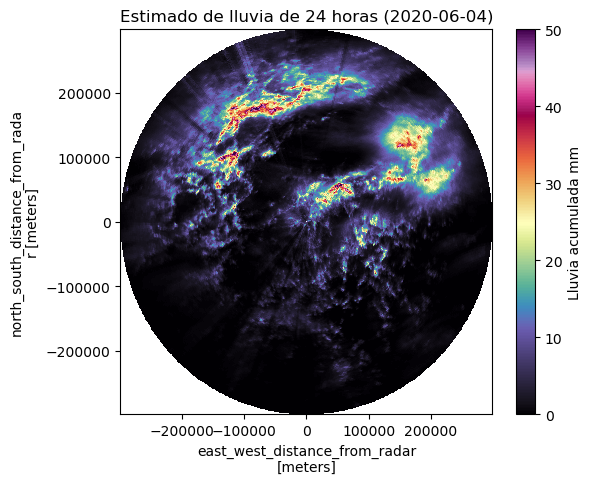

In [45]:
%%time
fig, ax = plt.subplots(figsize=(6, 5))
c = rain_total.plot(
    x='x', 
    y='y', 
    cmap='ChaseSpectral', 
    vmin=0,
    vmax=50,
    add_colorbar=False
)
plt.colorbar(c, ax=ax, label="Lluvia acumulada mm")
ax.set_title("Estimado de lluvia de 24 horas (2020-06-04)")